<a href="https://colab.research.google.com/github/hrishipoola/Product_Pareto_Apriori_Association/blob/main/Product_Focus_%26_Recs_using_Pareto%2C_Apriori%2C_%26_Association.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Product Pareto, Apriori, & Association

## Table of Contents
1. Introduction
2. Install & Import Packages
3. Exploration
<br> Countries
<br> Top 10 Products by Frequency, Quantity, Total Sales
<br> Low-Price Transactions
4. Pareto
5. Apriori (Pruning Item Sets)
6. Association Rules
<br> Pruning
<br> Heatmap
<br> Parallel Plot
7. References

## 1. Introduction

Let's work with the retail transactions data we [cleaned and processed](https://github.com/hrishipoola/Product_Pareto_Apriori_Association), focusing on customers from Germany. We'll explore Top 10 products and apply Pareto, or the 80/20 rule, in which roughly 80% of effects come from 20% of the causes (e.g., 20% of products generate 80% of sales). This can help us focus on the core group of customers and products that generate the overwhelming majority of sales. In the future, we'll explore time series trends with this data set in more depth. 

Next, we'll uncover products that are more likely to be purchased together in order to develop recommendations and bundles. If you want to learn about market basket concepts, including association metrics and pruning, in more depth, check out [Datacamp's Market Basket Analysis course](https://learn.datacamp.com/courses/market-basket-analysis-in-python). As a large set of unique items creates an unmanageable number of combinations and association rules, we'll first apply the Apriori algorithm to prune item sets. Apriori is based on the principle that subsets of frequent sets are also frequent and prunes large numbers of item sets by only focusing on items that have a minimum level of support (purchase frequency). We'll also visualize how different levels of minimum support affect the number of item sets created. 

Even a pruned frequent item set can generate an unruly number of association rules. Let's prune our association rules to a more manageable handful. For the pruning metric, let's choose lift, a measure of likelihood for items to co-occur. Lift is >1 for items that co-occur more than we'd expect if they were independently distributed across transactions. We'll also visualize how the number of association rules changes with increasing levels of lift criteria. We'll uncover products more likely to be purchased together that we can use to develop recommendations or bundle. Lastly, we'll visualize these associations through a heatmap and a parallel plot.  



## 2. Install & Import Packages

In [235]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import date, timedelta
from datetime import date

from mlxtend.frequent_patterns import apriori, association_rules
from pandas.plotting import parallel_coordinates

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
sns.set_style("darkgrid")
style.use('fivethirtyeight')

import io
from io import BytesIO
from zipfile import ZipFile

In [176]:
# Mount google drive
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [177]:
from google.colab import files
uploaded = files.upload()

Saving online_retail_processed.csv.gz to online_retail_processed.csv (1).gz


## 3. Exploration

In [353]:
df = pd.read_csv('online_retail_processed.csv.gz', compression='gzip')
df.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Description,TotalPrice,Year,Month,Day,DayName,Hour,Holiday
0,536365,85123A,6,2010-12-01 08:26,2.95,17850,UNITED KINGDOM,CREAM HANGING HEART T-LIGHT HOLDER,17.7,2010,12,1,Wednesday,8,0
1,536365,71053,6,2010-12-01 08:26,3.75,17850,UNITED KINGDOM,WHITE METAL LANTERN,22.5,2010,12,1,Wednesday,8,0
2,536365,84406B,8,2010-12-01 08:26,4.15,17850,UNITED KINGDOM,CREAM CUPID HEARTS COAT HANGER,33.2,2010,12,1,Wednesday,8,0
3,536365,84029G,6,2010-12-01 08:26,4.25,17850,UNITED KINGDOM,KNITTED UNION FLAG HOT WATER BOTTLE,25.5,2010,12,1,Wednesday,8,0
4,536365,84029E,6,2010-12-01 08:26,4.25,17850,UNITED KINGDOM,RED WOOLLY HOTTIE WHITE HEART,25.5,2010,12,1,Wednesday,8,0


Let's take a look at the countries with the highest number of transactions. The overwhelming majority are in the UK. 

In [354]:
df.groupby('Country', as_index=False)['InvoiceNo'] \
  .count() \
  .sort_values('InvoiceNo', ascending = False) \
  .reset_index(drop=True) \
  .head(10)

,Country,InvoiceNo
0,UNITED KINGDOM,353985
1,GERMANY,8658
2,FRANCE,8034
3,IRELAND,7136
4,SPAIN,2441
5,NETHERLANDS,2322
6,BELGIUM,1910
7,SWITZERLAND,1795
8,PORTUGAL,1425
9,AUSTRALIA,1250


## Germany Top 10

Going forward, let's focus on the Germany market.

### Frequency

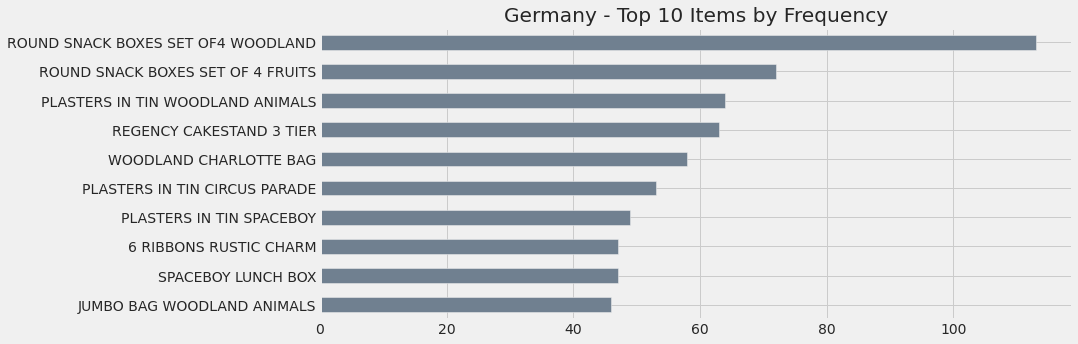

In [355]:
df[df.Country =='GERMANY'].Description.value_counts() \
                          .head(10) \
                          .sort_values(ascending=False) \
                          .iloc[::-1] \
                          .plot(kind='barh', 
                                x='Description', 
                                y='Frequency', 
                                legend=False, 
                                title='Germany - Top 10 Items by Frequency',
                                color='slategray',
                                figsize=(12,5))

### Quantity

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


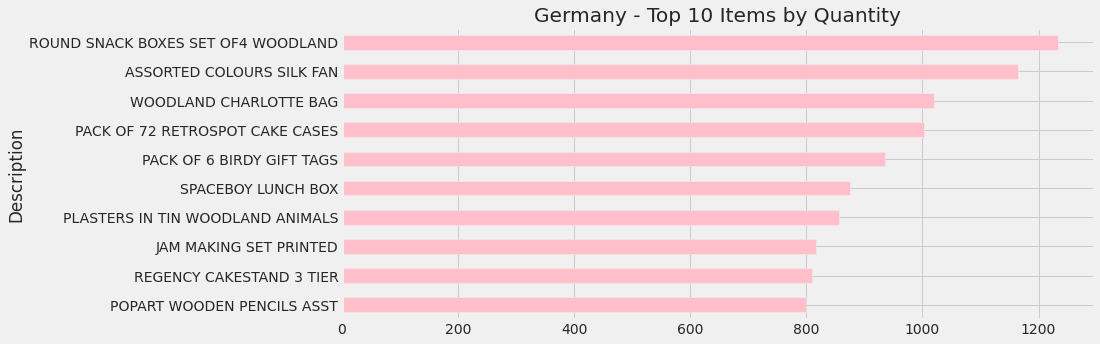

In [356]:
df[df.Country =='GERMANY'].groupby('Description', as_index=False)['Quantity','TotalPrice'] \
                          .sum() \
                          .sort_values(by='Quantity', ascending=False) \
                          .head(10) \
                          .iloc[::-1] \
                          .plot(kind='barh', 
                                x='Description', 
                                y='Quantity', 
                                legend=False, 
                                title='Germany - Top 10 Items by Quantity',
                                color='pink',
                                figsize=(12,5))

### Total Sales

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


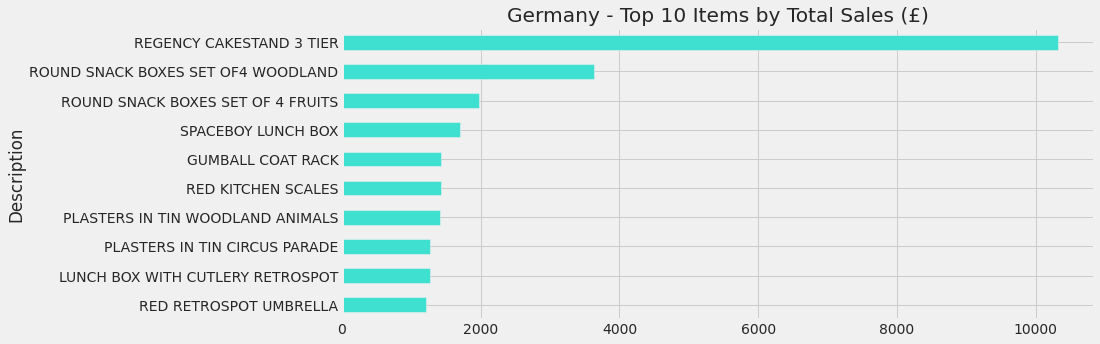

In [357]:
# Top 10 items by total price
df[df.Country =='GERMANY'].groupby('Description', as_index=False)['Quantity','TotalPrice'] \
                          .sum() \
                          .sort_values(by='TotalPrice', ascending=False) \
                          .head(10) \
                          .iloc[::-1] \
                          .plot(kind='barh', 
                                x='Description', 
                                y='TotalPrice', 
                                legend=False, 
                                title='Germany - Top 10 Items by Total Sales (£)',
                                color='turquoise',
                                figsize=(12,5))

### Low-Price Transactions

In [358]:
germany = df[df.Country =='GERMANY']

In [359]:
low_price_transactions = len(germany[germany.UnitPrice <= 5])/len(germany.UnitPrice)*100
print("{:.2f} % of transactions were for items 5 pounds or less.".format(low_price_transactions))

88.76 % of transactions were for items 5 pounds or less.


In [360]:
low_price_sales = germany[germany.UnitPrice<=5].TotalPrice.sum()/germany.TotalPrice.sum()*100
print("{:.2f} % of total sales come from items priced 5 pounds or less.".format(low_price_sales))

77.53 % of total sales come from items priced 5 pounds or less.


## 4. Pareto

Let's also apply Pareto, or the 80/20 rule, in which roughly 80% of effects come from 20% of the causes (e.g., 20% of products generate 80% of sales). This can help the retailer understand and focus on the core group of customers or products that generate the vast majority of sales. 


In [361]:
def pareto(df, variable_20_percent, measure):
    '''
    # Returns contribution of 20% of a cause variable to 80% of sales
    df: dataset 
    variable_20_percent: column to be checked for 20% of its unique entries to affect 80% of sales
    measure: string - the measure that is conributing to 80%
    '''
    pareto_df = df.groupby(variable_20_percent, as_index=False)['TotalPrice'].sum().sort_values(by='TotalPrice', ascending=False)
    pareto_df['Cumulative_Percentage'] = round(pareto_df['TotalPrice'].cumsum() / pareto_df['TotalPrice'].sum()*100,2)

    # Number of products that make up 80% of sales
    percent_80 = pareto_df[pareto_df['Cumulative_Percentage'] <= 80]
    item_num = percent_80[variable_20_percent].nunique()
    item_percent = round(item_num / df[variable_20_percent].nunique()*100,2)

    print(item_percent, '% of', measure, 'generated 80% of sales') 
    print(item_percent,'% means', item_num, measure)

In [362]:
pareto(germany, 'Description', 'products')

27.63 % of products generated 80% of sales
27.63 % means 459 products


In [363]:
pareto(germany, 'CustomerID', 'customers')

32.98 % of customers generated 80% of sales
32.98 % means 31 customers


In Germany, 80% of sales come from just 31 customers. 

## 5. Apriori (Pruning Item Sets)

A large set of unique items creates an unmanageable number of combinations and association rules. The apriori algorithm is based on the principle that subsets of frequent sets are also frequent and prunes large numbers of item sets by only focusing on items that have a minimum level of support (purchase frequency).


Apriori requires onehot encoded items as input so let's create one

In [364]:
def encode(x):
    if x <= 0:
        return 0
    else:
        return 1

def create_encoded_basket(df, country):
    
    # Returns one-hot-encoded basket of items. Inputs are df and country as all caps string in quotes
    global basket
    basket = df[df.Country == country].groupby(['InvoiceNo', 'Description'])['Quantity'] \
                                      .sum() \
                                      .unstack() \
                                      .fillna(0)

    basket = basket.applymap(encode)
    return basket

create_encoded_basket(df, 'GERMANY')

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,12 PENCILS TALL TUBE WOODLAND,12 PINK HEN+CHICKS IN BASKET,12 RED ROSE PEG PLACE SETTINGS,16 PC CUTLERY SET PANTRY DESIGN,2 PICTURE BOOK EGGS EASTER BUNNY,2 PICTURE BOOK EGGS EASTER CHICKS,20 DOLLY PEGS RETROSPOT,200 BENDY SKULL STRAWS,200 RED + WHITE BENDY STRAWS,3 DRAWER ANTIQUE WHITE WOOD CABINET,3 HOOK HANGER MAGIC GARDEN,3 HOOK PHOTO SHELF ANTIQUE WHITE,3 PIECE SPACEBOY COOKIE CUTTER SET,3 RAFFIA RIBBONS 50'S CHRISTMAS,3 STRIPEY MICE FELTCRAFT,3 TIER CAKE TIN GREEN AND CREAM,3 TIER CAKE TIN RED AND CREAM,3 TIER SWEETHEART GARDEN SHELF,3 TRADITIONAL BISCUIT CUTTERS SET,36 DOILIES DOLLY GIRL,36 FOIL HEART CAKE CASES,36 FOIL STAR CAKE CASES,36 PENCILS TUBE RED RETROSPOT,36 PENCILS TUBE SKULLS,36 PENCILS TUBE WOODLAND,3D CHRISTMAS STAMPS STICKERS,3D TRADITIONAL CHRISTMAS STICKERS,3D VINTAGE CHRISTMAS STICKERS,4 LAVENDER BOTANICAL DINNER CANDLES,4 TRADITIONAL SPINNING TOPS,...,WORLD WAR 2 GLIDERS ASSTD DESIGNS,WRAP VINTAGE DOILEY,WRAP 50'S CHRISTMAS,WRAP ALPHABET DESIGN,WRAP ALPHABET POSTER,WRAP BAD HAIR DAY,WRAP BILLBOARD FONTS DESIGN,WRAP BIRD GARDEN,WRAP CAROUSEL,WRAP CHRISTMAS SCREEN PRINT,WRAP CIRCUS PARADE,WRAP COWBOYS,WRAP DOLLY GIRL,WRAP ENGLISH ROSE,WRAP FLOWER SHOP,WRAP FOLK ART,WRAP GREEN PEARS,WRAP I LOVE LONDON,WRAP MAGIC FOREST,WRAP MONSTER FUN,WRAP PAISLEY PARK,WRAP PINK FAIRY CAKES,WRAP POPPIES DESIGN,WRAP RED APPLES,WRAP RED DOILEY,WRAP SUKI AND FRIENDS,WRAP VINTAGE LEAF DESIGN,WRAP WEDDING DAY,YELLOW COAT RACK PARIS FASHION,YOU'RE CONFUSING ME METAL SIGN,YULETIDE IMAGES GIFT WRAP SET,ZINC HEART T-LIGHT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC BOX SIGN HOME,ZINC FOLKART SLEIGH BELLS,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC WILLIE WINKIE CANDLE STICK
InvoiceNo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
536527,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
536840,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
536861,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
536967,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
536983,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581266,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
581494,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
581570,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Let's see how the number of itemsets is pruned by minimum level of support.  

Text(0.5, 1.0, 'Number of Itemsets vs. Minimum Support')

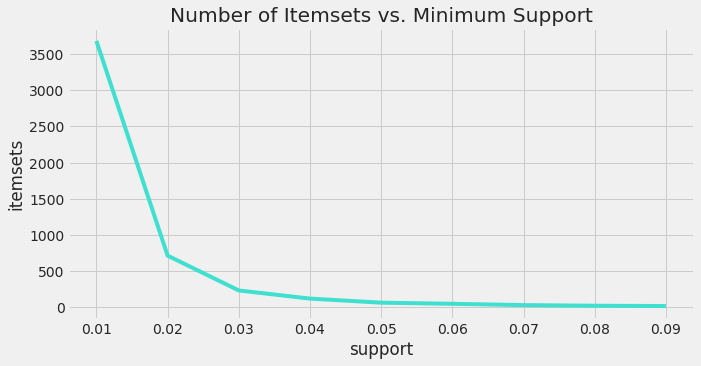

In [365]:
# Plot size of frequent itemsets vs minimum support level
supports = list(np.arange(0.01, 0.10, 0.01))
itemsets = []

for support in supports:
    frequent_itemsets = apriori(basket, min_support = support, max_len=3, use_colnames = True)
    num_itemsets = len(frequent_itemsets)
    itemsets.append(num_itemsets)

plot_itemsets = pd.DataFrame(list(zip(supports, itemsets)), columns=['support','itemsets'])
plt.figure(figsize=(10,5))
sns.lineplot(data=plot_itemsets, x='support', y='itemsets', color='turquoise')
plt.title('Number of Itemsets vs. Minimum Support')

We can see the number of frequent itemsets drops dramatically with higher support levels. Let's choose 0.05 for our minimum level of support. 

In [366]:
# Apriori to select the most important itemsets
itemsets = apriori(basket, min_support = 0.05, max_len=3, use_colnames = True)
itemsets.sort_values('support', ascending = False).head()

,support,itemsets
35,0.252822,(ROUND SNACK BOXES SET OF4 WOODLAND)
34,0.162528,(ROUND SNACK BOXES SET OF 4 FRUITS)
31,0.142212,(REGENCY CAKESTAND 3 TIER)
24,0.142212,(PLASTERS IN TIN WOODLAND ANIMALS)
57,0.135440,"(ROUND SNACK BOXES SET OF4 WOODLAND, ROUND SNA..."


In [367]:
print('Number of frequent itemsets:', len(itemsets))

Number of frequent itemsets: 60


## 6. Association Rules

### Pruning


Even a pruned frequent item set can generate an unruly number of association rules. Let's prune our association rules to a more manageable handful. For the pruning metric, let's choose lift, a measure of likelihood for items to co-occur. Lift is >1 for items that co-occur more than we'd expect if they were independently distributed across transactions. We'll also visualize how the number of association rules changes with increasing levels of lift criteria.

Text(0.5, 1.0, 'Number of Association Rules vs. Lift Threshold')

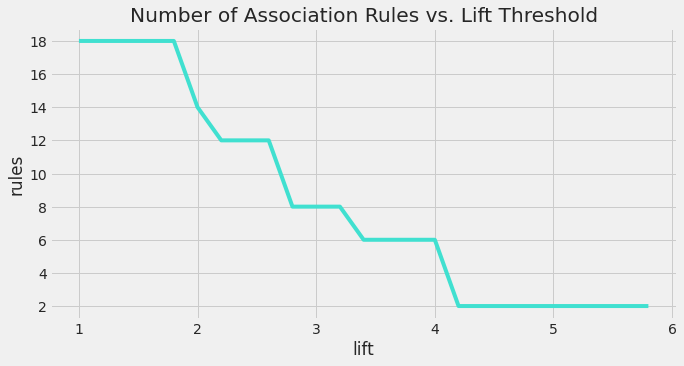

In [368]:
# Plot number of association rules vs lift threshold
lifts = list(np.arange(1, 6, 0.2))
rules = []

for lift in lifts:
    associations = association_rules(itemsets, metric = 'lift', min_threshold = lift)
    num_rules = len(associations)
    rules.append(num_rules)

plot_rules = pd.DataFrame(list(zip(lifts, rules)), columns=['lift','rules'])
plt.figure(figsize=(10,5))
sns.lineplot(data=plot_rules, x='lift', y='rules', color='turquoise')
plt.title('Number of Association Rules vs. Lift Threshold')

Let's choose a lift threshold of 2.5 to get to a manageable number of rules. 

In [369]:
associations = association_rules(itemsets, metric = 'lift', min_threshold = 2.5)
associations.sort_values('lift', ascending=False).reset_index(drop=True)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(RED RETROSPOT CHARLOTTE BAG),(WOODLAND CHARLOTTE BAG),0.072235,0.130926,0.060948,0.843750,6.444504,0.051491,5.562077
1,(WOODLAND CHARLOTTE BAG),(RED RETROSPOT CHARLOTTE BAG),0.130926,0.072235,0.060948,0.465517,6.444504,0.051491,1.735819
2,(PLASTERS IN TIN CIRCUS PARADE),(PLASTERS IN TIN WOODLAND ANIMALS),0.119639,0.142212,0.069977,0.584906,4.112908,0.052963,2.066489
3,(PLASTERS IN TIN WOODLAND ANIMALS),(PLASTERS IN TIN CIRCUS PARADE),0.142212,0.119639,0.069977,0.492063,4.112908,0.052963,1.733211
4,(PLASTERS IN TIN SPACEBOY),(PLASTERS IN TIN WOODLAND ANIMALS),0.110609,0.142212,0.063205,0.571429,4.018141,0.047475,2.001505
5,(PLASTERS IN TIN WOODLAND ANIMALS),(PLASTERS IN TIN SPACEBOY),0.142212,0.110609,0.063205,0.444444,4.018141,0.047475,1.600903
6,(ROUND SNACK BOXES SET OF4 WOODLAND),(ROUND SNACK BOXES SET OF 4 FRUITS),0.252822,0.162528,0.135440,0.535714,3.296131,0.094350,1.803785
7,(ROUND SNACK BOXES SET OF 4 FRUITS),(ROUND SNACK BOXES SET OF4 WOODLAND),0.162528,0.252822,0.135440,0.833333,3.296131,0.094350,4.483070
8,(SPACEBOY LUNCH BOX),(ROUND SNACK BOXES SET OF4 WOODLAND),0.106095,0.252822,0.072235,0.680851,2.693009,0.045412,2.341159
9,(ROUND SNACK BOXES SET OF4 WOODLAND),(SPACEBOY LUNCH BOX),0.252822,0.106095,0.072235,0.285714,2.693009,0.045412,1.251467


In [370]:
print('Number of association rules:', len(associations))

Number of association rules: 12


A few insights: 

- Customer is 6.5x as likely to buy WOODLAND CHARLOTTE BAG than an average customer (lift) if they buy RED RETROSPOT CHARLOTTE BAG. This rule is true in 84% of transactions (confidence) 

- Customer is 4.11x as likely to buy PLASTERS IN TIN WOODLAND ANIMALs than an average customer if they buy PLASTERS IN TIN CIRCUS PARADE. This rule is true in 58% of transactions. 

- Customer is 3.3x as likely to buy ROUND SNACK BOXES SET OF 4 WOODLAND than an average customer if they buy ROUND SNACK BOXES SET OF 4 FRUITS. This rule is true in 83% of transactions. 

We can use this to recommend or bundle these pairs of products together. 




### Heatmap

A heatmap makes the association rules and lift metrics across antecedents and consequents easier to see. 

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 <a list of 8 Text major ticklabel objects>)

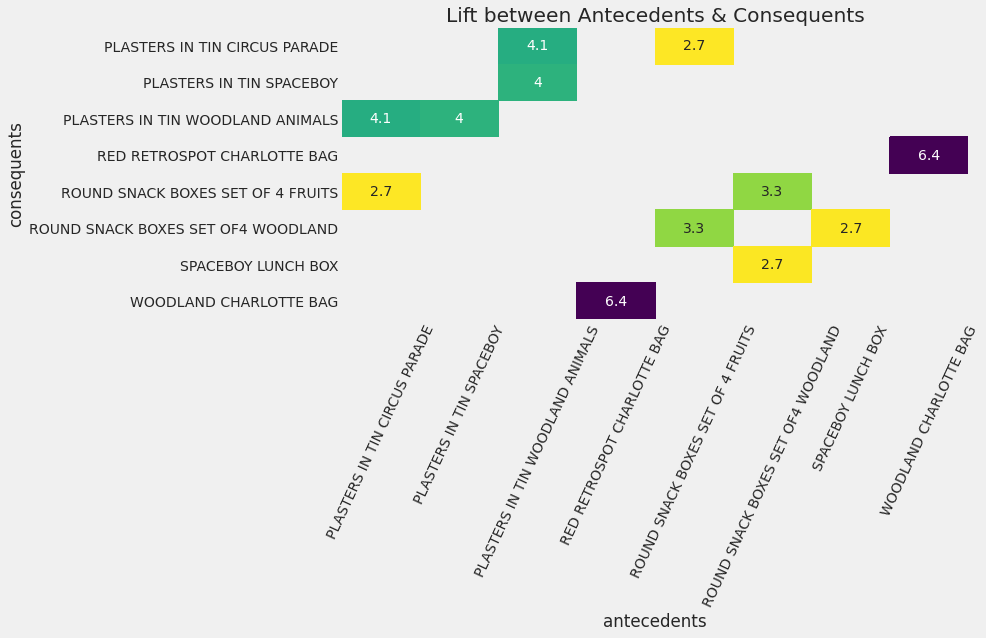

In [371]:
# association_rules returns frozen sets, let's convert them to strings
associations['antecedents'] = associations['antecedents'].apply(lambda a: ','.join(list(a)))
associations['consequents'] = associations['consequents'].apply(lambda a: ','.join(list(a)))

# Pivot data on consequents and antecedents with lift as values
pivot = associations.pivot(index='consequents', columns='antecedents', values='lift')

plt.figure(figsize=(10,5))
sns.heatmap(pivot, annot = True, cbar = False, cmap='viridis_r')
plt.title('Lift between Antecedents & Consequents')
plt.yticks(rotation=0)
plt.xticks(rotation=65)

### Parallel Plot

Let's plot association just the associations using a parallel plot. The consequents on the right are the same as the antecedents on the left. 

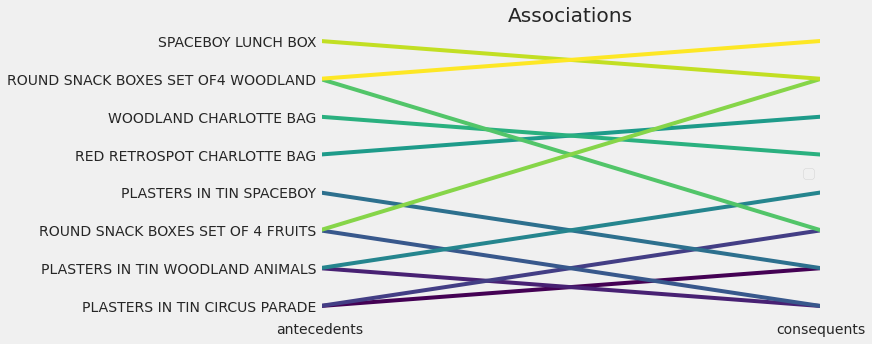

In [372]:
associations = association_rules(itemsets, metric = 'lift', min_threshold = 2.5)

# association_rules returns frozen sets, let's convert them to strings
associations['antecedents'] = associations['antecedents'].apply(lambda a: ','.join(list(a)))
associations['consequents'] = associations['consequents'].apply(lambda a: ','.join(list(a)))

# Create coordinates datafram from rules
associations['rule'] = associations.index
coords = associations[['antecedents', 'consequents', 'rule']]

plt.figure(figsize=(8,5))
parallel_coordinates(coords,'rule', colormap='viridis')
plt.title('Associations')
plt.legend('')

From the parallel plot, we can see:
- Some items like Spaceboy Lunch Box, Woodland Carhlotte Bag, Plasters in Tin Spaceboy have only one association
- Round Snack Boxes set of 4 fruits, Plasters in Tin Circus Parade, Plasters in Tin Circus Parade have multiple associations 

## 7. References

https://learn.datacamp.com/courses/market-basket-analysis-in-python

https://github.com/abhilashsinghcad/Data-Analysis---UK-Online-Retail/blob/master/Online%20Retail%20-%20Data%20Exploration%20and%20Customer%20Metrics.ipynb

https://github.com/SarahMestiri/online-retail-case/blob/master/Market%20Basket%20Analysis%20-%20Online%20Retail.ipynb

https://towardsdatascience.com/apriori-association-rule-mining-explanation-and-python-implementation-290b42afdfc6

https://www.kaggle.com/xvivancos/market-basket-analysis
